# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_probability import distributions as tfd
from sklearn.metrics import mean_absolute_error, mean_squared_error

from utils import *

##### Flags

In [2]:
# Set to true if you run on Google Colab
COLAB = False

# Set TRAIN to True if want to retrain the models
TRAIN = True

# Set EVALUATE_FEATURE_IMPORTANCE to True if want to evaluate the feature importance for the BNN model
EVALUATE_FEATURE_IMPORTANCE = False

# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

HUNDRED = 100
TWENTY = 20

GPU = True
if GPU:
    tf.config.set_visible_devices([], 'GPU')
    print("Using GPU")


Using GPU


## Data Analysis

In [3]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [4]:
DATA_PATH = "."

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_data_train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_data_test.pkl','rb'))

In [5]:
df_train.head()

,index,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
0,103052,2019-10-09 15:40:00,612.931889,117.853113,397.738037,789.362366,625.268222,6.922316,0.775613,5.464120,...,0.0,0.0,0.0,102.134432,456.456093,10.481703,47.967646,26.137451,1,2019
1,63535,2018-12-22 19:20:00,812.563049,127.390045,596.425964,987.356689,623.877258,6.916840,0.837299,5.161180,...,NaN,NaN,NaN,137.115128,620.665283,7.971515,37.439159,25.069386,1,2018
2,30251,2018-04-23 07:00:00,833.015015,178.888748,529.766296,1154.555420,650.319405,7.015926,0.996402,5.118486,...,NaN,NaN,NaN,149.870911,569.190796,9.258190,54.654232,34.426693,1,2018
3,138781,2020-06-16 05:20:00,-0.890103,0.124784,-1.120350,-0.629530,0.000000,2.538888,0.296080,1.866375,...,0.0,45.0,45.0,61.487915,324.860234,4.306723,5.041540,4.982683,1,2020
4,94560,2019-08-11 16:20:00,820.504449,194.314092,514.688721,1285.431152,750.737509,7.316579,0.959171,5.956026,...,0.0,0.0,0.0,154.446519,613.626147,8.222307,57.914969,32.184149,1,2019


In [6]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'
TURBINE_ID = 5

print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

TURBINE_ID = 5
df_train_single = df_train[df_train['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [7]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Rotor.bearing.temp.me,Stator1.temp.me,Nacelle.ambient.temp.me,Nacelle.temp.me,Transformer.temp.me,Gear.oil.temp.me,Gear.oil.inlet.temp.me,Top.box.temp.me,Hub.temp.me,Conv.Amb.temp.me,Transformer.cell.temp.me,Motor.axis1.temp.me,Motor.axis2.temp.me,CPU.temp.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me
count,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000
mean,6.061792,0.929598,4.285672,7.826800,65.249559,0.611390,64.235198,66.234087,63.228148,0.665511,62.131779,64.294001,25.147016,62.680004,10.395775,19.545742,48.827492,52.035799,48.283892,24.561808,20.016075,14.146877,16.435012,42.007367,42.461620,53.257354,4.664098,4.664053,4.664393,118.197068,459.291346,21.301466,57.177760,27.941015,624.587598
std,2.767883,0.461186,2.206099,3.482993,10.096854,0.504141,9.916454,10.287366,8.592414,0.576825,8.409253,8.819052,3.963058,7.853748,5.895684,5.386682,19.850288,5.862262,8.085823,3.431033,4.873869,6.028698,5.922955,18.629214,18.868266,3.212041,12.673886,12.673785,12.674054,54.677459,164.758023,36.644667,30.554552,15.813479,631.196896
min,0.129863,0.000000,-0.444250,0.243750,14.565001,0.000000,14.400000,14.600000,13.147500,0.000000,13.100000,13.200000,9.002500,13.720000,-6.800000,1.245000,18.690001,13.857500,9.235000,9.520000,7.762000,-2.642500,-1.037500,10.400000,11.000000,38.000000,0.000000,0.000000,0.000000,-4.160219,5.963073,3.013230,1.225289,2.458500,-21.170280
25%,4.052706,0.595049,2.674919,5.362026,61.002500,0.236114,60.099998,61.900002,61.092499,0.240885,60.400002,61.849998,22.215000,59.665001,6.020000,15.917500,35.562500,49.326313,42.110000,22.900000,16.043158,9.677500,11.925000,27.074500,28.000000,52.000000,0.000000,0.000000,0.000000,83.152820,352.544764,4.978957,36.144118,17.303601,122.224066
50%,5.707567,0.851638,4.071932,7.317771,69.794736,0.475730,68.449997,70.900002,66.140001,0.477723,65.050003,67.000000,25.049999,62.027500,9.690000,19.530000,42.087499,53.122500,50.200000,24.920000,19.000000,13.590000,16.092500,36.849998,37.124000,53.525002,0.026500,0.026500,0.026500,98.062714,404.299846,7.397583,54.777193,25.706060,382.674857
75%,7.657582,1.180467,5.618109,9.794380,72.277500,0.845470,71.199997,73.300003,68.575001,0.928453,67.199997,70.000000,28.059524,64.492499,14.352500,23.075000,54.002631,56.322498,55.132500,26.395000,23.196500,18.242500,20.514999,54.286500,54.245499,55.000000,1.116000,1.116000,1.117000,151.218739,564.198951,14.488859,77.716939,35.893112,967.920566
max,22.151195,5.016237,17.995665,32.264656,81.182500,7.816919,80.800003,81.449997,75.092500,7.473754,74.649994,76.400002,39.097499,103.014999,35.225000,39.430000,107.987503,59.926316,60.208335,39.863889,38.359000,43.762500,42.076316,85.001000,87.000000,68.900000,89.989998,89.989998,90.000000,305.390411,1169.453369,327.393707,272.232208,192.845093,2084.067871


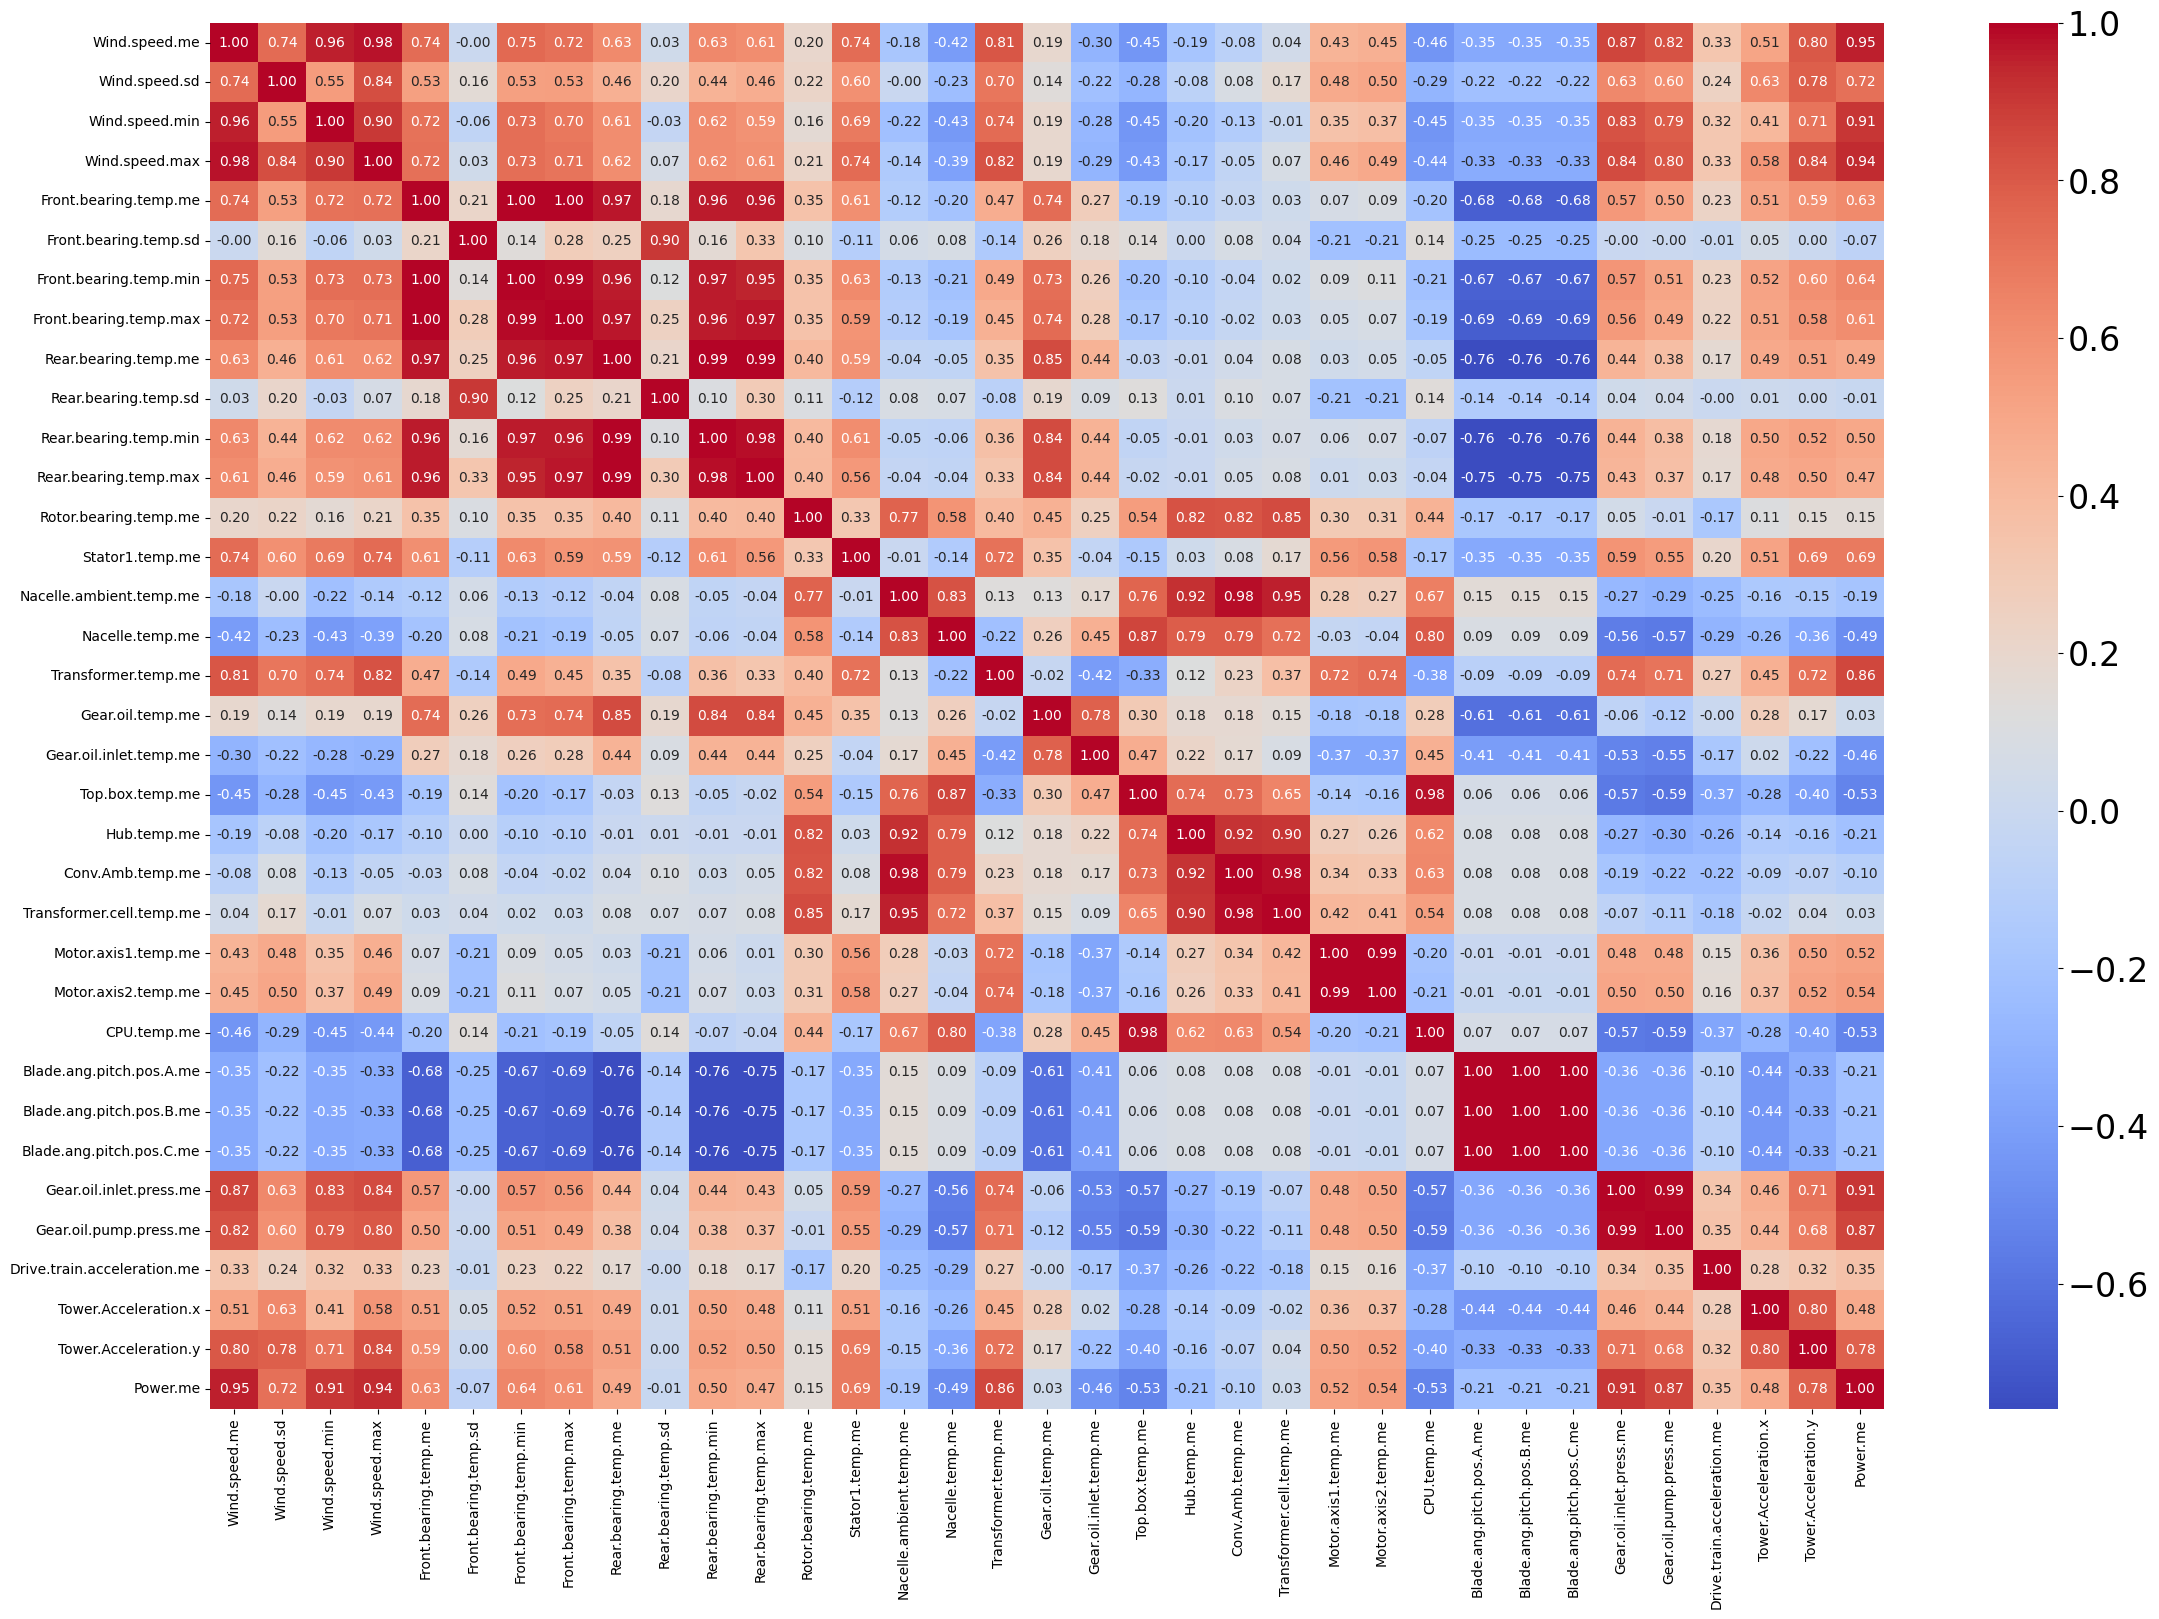

In [8]:
plt.figure(figsize=(27, 18))
correlation_matrix = df_train_single[features + [output_feature]].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

plt.show()

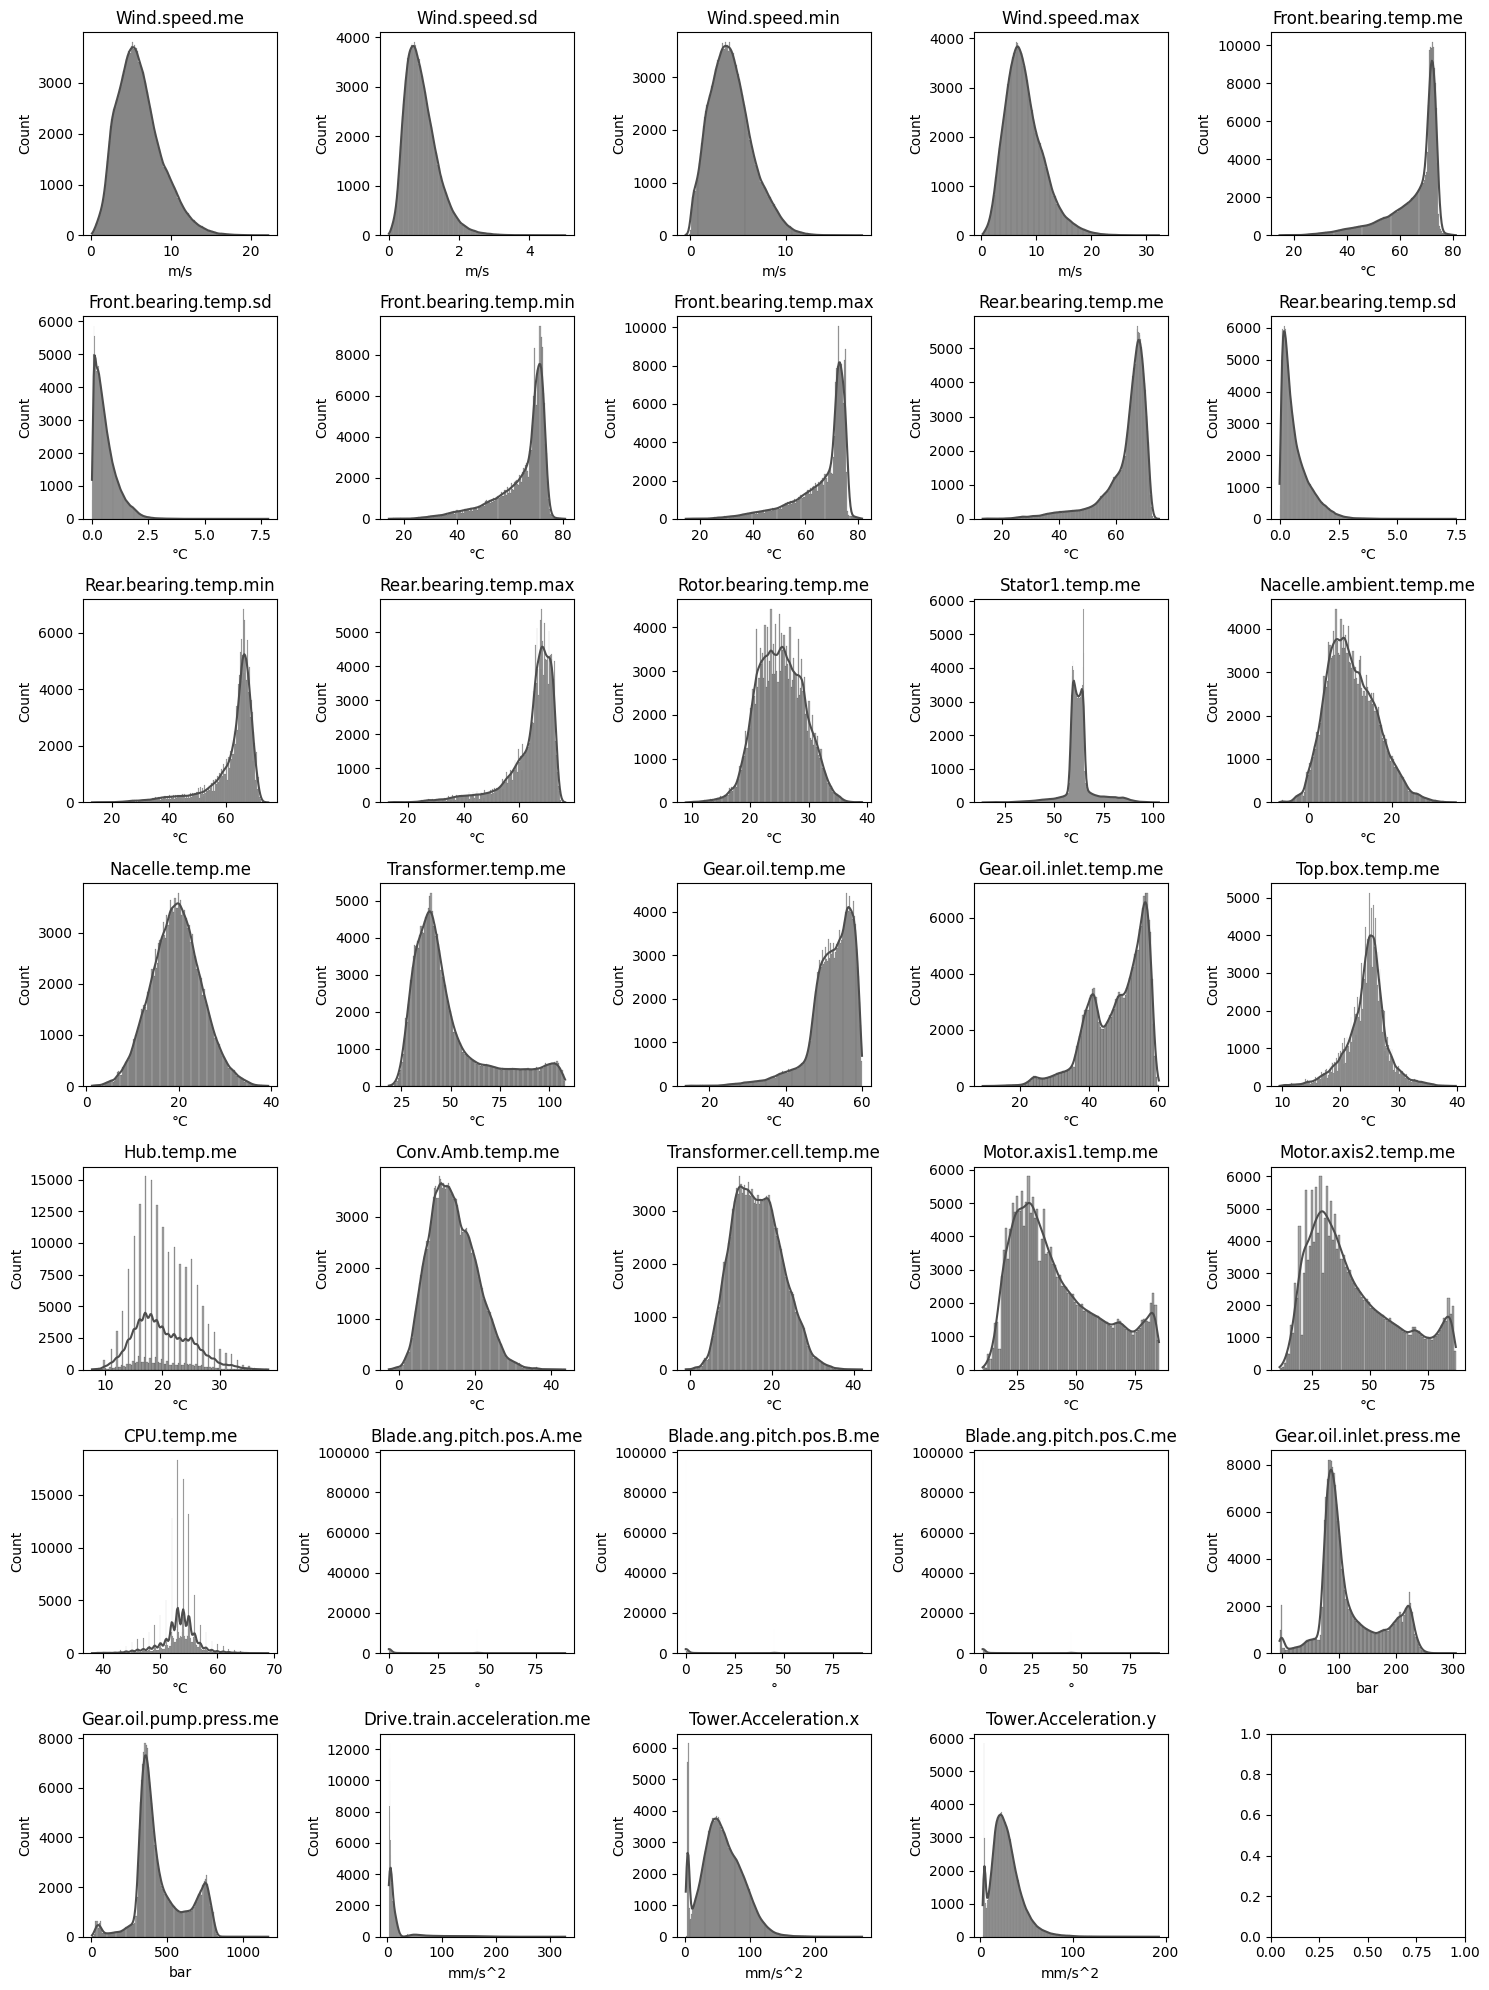

In [9]:
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i], color="0.3")
    axes[i].set_title(feature)
    axes[i].set_xlabel(units[feature])
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

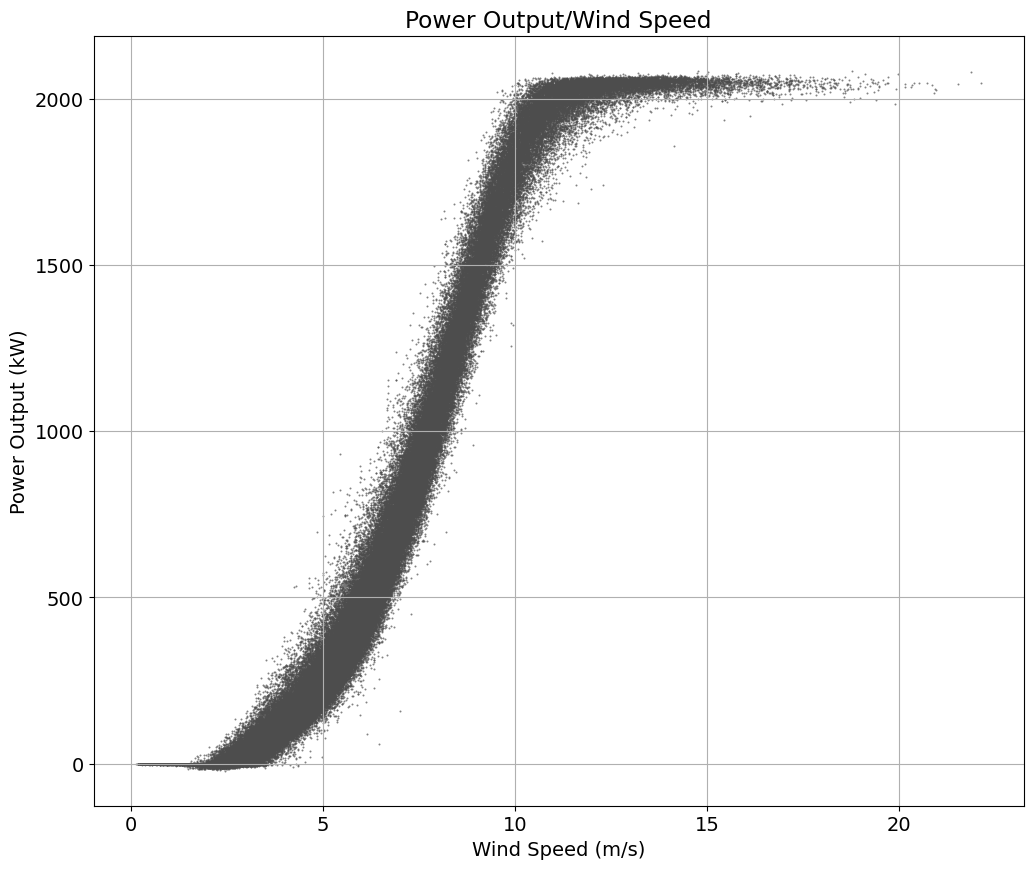

In [11]:
# Plot Power over Wind Speed
plt.rc('font', size=14)
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

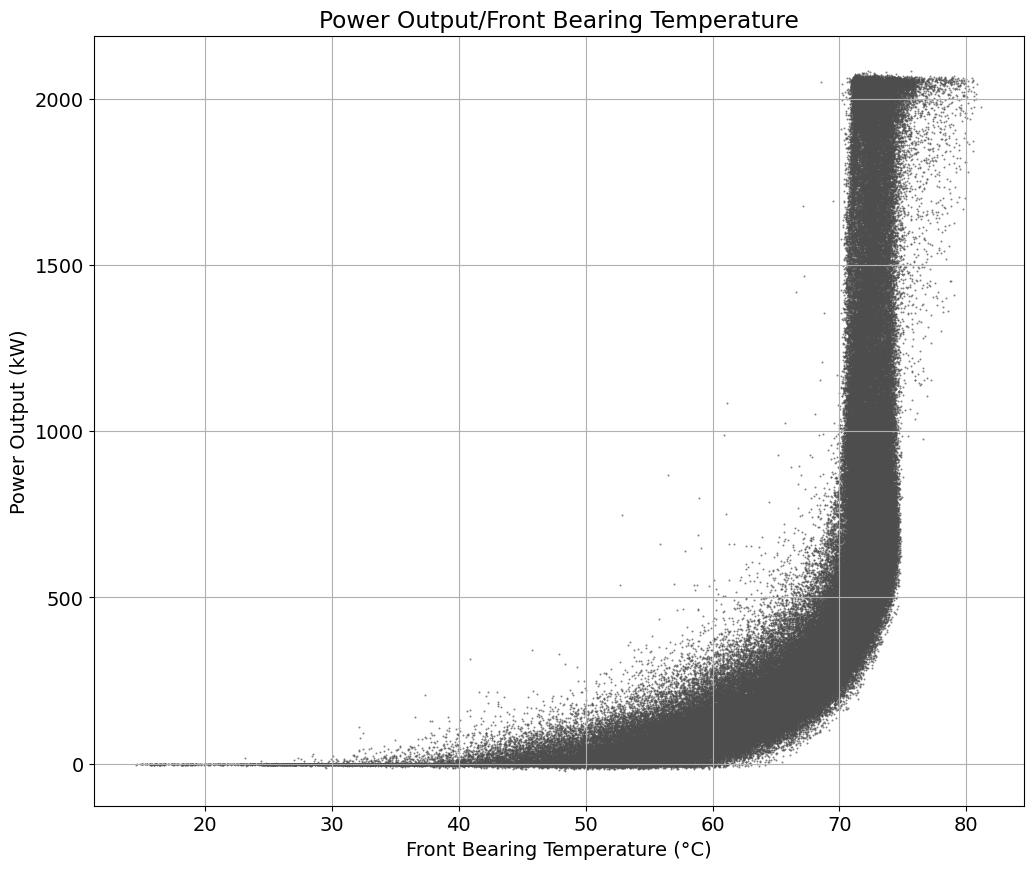

In [12]:
# Plot Power over Front Bearing Temperature
plt.rc('font', size=14)
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

In [ ]:
plot_power_over_all_features(df, units, features, output_feature, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [14]:
X_train_full, X_test_full,\
    y_train_full, y_test_full,\
    scaler_full = create_design_matrix(df_train, df_test, features, output_feature)

X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, features, output_feature)

assert X_train.shape[0] < X_train_full.shape[0]

In [ ]:
X_train.shape

### Deterministic (Homoscedastic) MLP

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [ ]:
def create_model_mlp_non_probabilistic(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    hidden = Dense(80, activation="relu")(inputs)
    hidden = Dense(50, activation="relu")(hidden)
    hidden = Dense(20, activation="relu")(hidden)
    output = Dense(1, activation="linear")(hidden) 

    model_mlp_non_probabilistic = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model_mlp_non_probabilistic

model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train, MODELS_SEED)
model_path = "mlp"

In [ ]:
if TRAIN == True:

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic,
                          X_train, y_train,
                          patience=10, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_mlp_non_probabilistic.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_mlp_non_probabilistic.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_save_metrics("Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (/Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [ ]:
SAMPLE_PERCENTAGE = 0.01
np.random.seed(MODELS_SEED)

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [ ]:
def create_model_mlp_non_probabilistic_bnn_flipout(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)
    
    output = tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)

    model_mlp_non_probabilistic_bnn = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic_bnn.compile(Adam(learning_rate=0.001), loss='mean_squared_error')

    return model_mlp_non_probabilistic_bnn

print(X_train_sampled.shape[1])

model_mlp_non_probabilistic_bnn_flipout_sample = create_model_mlp_non_probabilistic_bnn_flipout(X_train_sampled, MODELS_SEED)
model_path = "bnn_non_prob_sample"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout_sample,
                          X_train_sampled, y_train_sampled,
                          patience=20, epochs=HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout_sample, X_train, X_test, num_samples=TWENTY)

In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_save_metrics(f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [ ]:
model_mlp_non_probabilistic_bnn_flipout = create_model_mlp_non_probabilistic_bnn_flipout(X_train, MODELS_SEED)
model_path = "bnn_non_prob"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout,
                          X_train, y_train,
                          patience=20, epochs=4*HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_mlp_non_probabilistic_bnn_flipout.evaluate(X_test, y_test)

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout, X_train, X_test, num_samples=TWENTY)

In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_save_metrics("Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

##### Feature Importance

For the interest of the field we evaluate the raw feature importance within the Bayesian network. Let's evaluate feature importance for the BNN with deterministic output. We do this only for the deterministic output because the RATE library does not support probabilistic regressions (see https://github.com/lorinanthony/RATE). To do so we retrain the model wrapped into a BNN_Regressor class from the RATE library.

For installation, see https://github.com/lorinanthony/RATE/tree/master/Software/rate-bnn

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    from rate import *
    
    p = X_test.shape[1]

    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

    layers = []

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            input_shape=(p,),
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "linear"
        ))

    bnn = BNN_Regressor(layers, p=p)
    fit_history = bnn.fit(X_train, y_train, epochs=HUNDRED//2, batch_size=256, validation_split=0.1,
                        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                        verbose=0)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    ratings = RATE_BNN(bnn, X_test_sampled, n_workers=1)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    rates = RATE_BNN(bnn, X_test_sampled, n_workers=1)
    feature_importance = {feature: rate for feature, rate in zip(features, list(rates[0]))}

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())

    plt.figure(figsize=(10, 12))
    plt.barh(features, importance_values, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')

    for i, importance in enumerate(importance_values):
        plt.text(importance, i, f'{importance*100:.2f}', va='center')

    plt.xlim(0, max(importance_values) + 0.02)
    plt.tight_layout()
    plt.show()

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [ ]:
def create_model_bnn(X_train, seed):
    keras.utils.set_random_seed(seed) 
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
        
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=80,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=50,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    # Output Univariate Normal Probabilistic Layer
    dist_params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(dist_params)

    model_bnn = Model(inputs=inputs, outputs=dist)
    model_bnn.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_bnn

model_bnn = create_model_bnn(X_train, MODELS_SEED)
model_path = "bnn"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_bnn,
                          X_train, y_train,
                          patience=10, epochs=HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_bnn.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_bnn.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

name = "Stochastic Output BNN (Flipout)"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

## Non-Bayesian MLP (Probabilistic Output) 
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### MLP with Normal Output - Separate Submodels

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [ ]:
def create_model_mlp_gaussian_separate(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    mean_h1 = Dense(80, activation="relu")(inputs)
    variance_h1 = Dense(80, activation="relu")(inputs)
    
    mean_h2 = Dense(50, activation="relu")(mean_h1)
    variance_h2 = Dense(50, activation="relu")(variance_h1)
    
    mean_h3 = Dense(20, activation="relu")(mean_h2)
    variance_h3 = Dense(20, activation="relu")(variance_h2)
    
    mean_h4 = Dense(20, activation="relu")(mean_h3)
    variance_h4 = Dense(20, activation="relu")(variance_h3)
    
    mean_out = Dense(1)(mean_h4)
    variance_out = Dense(1)(variance_h4)
    
    params = Concatenate()([mean_out, variance_out])
    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train, MODELS_SEED)
model_path = "mlp_sep"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_separate,
                          X_train, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_separate.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_mlp_gaussian_separate.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_save_metrics("Probabilistic MLP (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

### MLP with Gaussian Output - Joint Submodels

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [15]:
def create_model_mlp_gaussian_joint(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)
model_path = "mlp_joint"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_joint.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_mlp_gaussian_joint.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

name = "Probabilistic MLP (Joint Sub-models)"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

By comparing the two architecture it is clear that a separate set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the first. 

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def create_model_cnn_gaussian(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    conv1d_layer = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
    maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
    
    flatten_layer = Flatten()(maxpooling_layer)
 
    hidden1 = Dense(50, activation="relu")(flatten_layer)
    hidden2 = Dense(50, activation="relu")(hidden1)
    hidden3 = Dense(20, activation="relu")(hidden2)
    
    params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_cnn_gaussian = Model(inputs=inputs, outputs=dist)
    model_cnn_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)
    
    return model_cnn_gaussian

model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn, MODELS_SEED)
model_path = "cnn"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_cnn_gaussian,
                          X_train_cnn, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_cnn_gaussian.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

In [ ]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_save_metrics("Probabilistic CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the initial Convolution layer have little significanceas they are dependent on the ordering of the features, which have no spacial dependency. This means the subsequent layers have to unpack the convolution and pooling to learn meaningful features.  

## Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [ ]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [ ]:
# Specify the number of turbines to consider
turbine_num = 6

# Select the n turbines with the most common non-NaN data points
turbine_counts = df_train.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_n = df_train[df_train['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_n, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [ ]:
df_multivariate.head()

In [ ]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [ ]:
print(X_train_mult.shape, y_train_mult.shape)

In [ ]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

### Diagonal Covariance Matrix

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. BY enforcing a diagnonal covariance matrix of the outpyt Normal density we do not model covariances between different turbines, therefore the loss can be decomposed into a sum of individual losses as follows:

$$
\mathcal{NLL}_d = \frac{1}{2} \sum_{i=1}^{n}\left[ d \cdot \log(2\pi) + \log(|\boldsymbol{\Sigma_{\boldsymbol{\theta}}}(\mathbf{x}_i)|) + (\mathbf{y}_i - \boldsymbol{\mu_{\boldsymbol{\theta}}}(\mathbf{x}_i))^T \boldsymbol{\Sigma^{-1}_{\boldsymbol{\theta}}}(\mathbf{x}_i) (\mathbf{y}_i - \boldsymbol{\mu_{\boldsymbol{\theta}}}(\mathbf{x}_i)) \right] \\
= \frac{1}{2} \sum_{i=1}^{n}  \left[ d \cdot \log(2\pi) + \sum_{j=1}^{d} \left[ \log(\sigma_{\boldsymbol{\theta}j}  (\mathbf{x}_i)) +\sigma^{-2}_{\boldsymbol{\theta}j}(\mathbf{x}_i)(\mathbf{y}_{ij} - \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_i))^2 \right] \right] \\
= \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{d} \left[ \log(2\pi) + \log(\sigma_{\boldsymbol{\theta}j}  (\mathbf{x}_i)) + \sigma^{-2}_{\boldsymbol{\theta}j}(\mathbf{x}_i)(\mathbf{y}_{ij} - \boldsymbol{\mu}_{\boldsymbol{\theta}j}(\mathbf{x}_i))^2 \right]
$$
where $\boldsymbol{\Sigma}_{jj} = \sigma^{2}_{\boldsymbol{\theta}j}$

Although the loss is separable, this is not identical to training individual models for each turbine because the input, and possibly network layers, are shared. We investigated two architectures with separate and shared hidden layers and showed that the architecture with separate hidden layers for each turbine produced better predictive results compared to the one with shared layers by allowing the network to learn turbine-specific features.

#### Separate Branches for Separate Turbines

In [ ]:
def create_model_multivariate_gaussian_only_diagonal(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []

    for i in range(d):
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        out = Dense(2)(Concatenate()([h_means3, h_cov3]))
        outs.append(out)

    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_diag"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)
    
    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Only Diagonal, separate branches)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], save_path=f"figures/{model_path}/preds{i+1}.png")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20, save_path=f"figures/{model_path}/cis{i+1}.png")

#### Common Branches for Separate Turbines

In [ ]:
def create_model_multivariate_gaussian_only_diagonal_common(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []
        
    h1 = Dense(100, activation='relu')(inputs)
    h2 = Dense(50, activation='relu')(h1)
    h3 = Dense(30, activation='relu')(h2)
    
    for i in range(d):
        out = Dense(2)(h3)
        outs.append(out)


    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal_common = create_model_multivariate_gaussian_only_diagonal_common(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_diag_common"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal_common,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal_common.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_only_diagonal_common.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

### Full Covariance Matrix: Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [ ]:
def create_model_multivariate_gaussian_with_covariance(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)

    h1_mean = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_mean = BatchNormalization()(Dense(70, activation='relu')(h1_mean))
    h3_mean = BatchNormalization()(Dense(50, activation='relu')(h2_mean))
    
    h1_cov = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_cov = BatchNormalization()(Dense(70, activation='relu')(h1_cov))
    h3_cov = BatchNormalization()(Dense(50, activation='relu')(h2_cov))
    
    out_mean = Dense(d, activation='linear')(h3_mean)
    out_cov = Dense(tfp.layers.MultivariateNormalTriL.params_size(d) - d)(h3_cov)
    
    # Concatenate mean and lower triangular part of the covariance matrix
    concatenated_outputs = Concatenate()([out_mean, out_cov])
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_covariance_normal_softplus(t[:, :d], t[:, d:], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001, clipnorm=100),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_full"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_with_covariance,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_with_covariance.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], save_path=f"figures/{model_path}/preds{i+1}.png")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20, save_path=f"figures/{model_path}/cis{i+1}.png")

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow for sufficiently reduced predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 

## Wind Farm Pre-training and Winf Turbine Fine-tuning

In [18]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models/pretrain.h5'

# Define the initial model architecture
def generic_model(X_train_full):
    inputs = Input(shape=(X_train_full.shape[1],))
    hidden1 = Dense(300, activation="relu")(inputs)
    hidden2 = Dense(200, activation="relu")(hidden1)
    hidden3 = Dense(100, activation="relu")(hidden2)

    params = Dense(2)(hidden3)

    dist = tfp.layers.DistributionLambda(normal_softplus)(params)

    model = Model(inputs=inputs, outputs=dist)
    model.compile(Adam(learning_rate=0.001), loss=NLL)

    return model

# Train the initial model using X_full with the checkpoint callback
generic_model = generic_model(X_train_full)
generic_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_8 (Dense)             (None, 300)               10500     
                                                                 
 dense_9 (Dense)             (None, 200)               60200     
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_1 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Load weights from the checkpoint if available
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading weights.")
    generic_model.load_weights(checkpoint_path)
    # Get the number of epochs already run
    start_epoch = generic_model.history.epoch[-1]
    print(f"Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Training from scratch.")
    start_epoch = 0

history = generic_model.fit(X_train_full, y_train_full, epochs=5*HUNDRED, batch_size=64, initial_epoch=start_epoch,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])

In [19]:
generic_model.load_weights(checkpoint_path)
evaluation = generic_model.evaluate(X_test_full, y_test_full)
print("Evaluation Loss:", evaluation)


6311/6311 [==============================] - 13s 2ms/step - loss: 4.0346
Evaluation Loss: 4.034616470336914


In [20]:
checkpoint_path = 'saved_models/finetuned.keras'

def create_model_finetune(X_train, generic_model, seed):
    keras.utils.set_random_seed(seed)

    inputs = Input(shape=(X_train.shape[1],))

    # Step 1: Load the architecture and weights of the previously trained model
    pretrained_model_layers = generic_model.layers[1:]
    l = inputs

    for layer in pretrained_model_layers:
        layer.trainable = True
        l = layer(l)

    model_mlp_gaussian = Model(inputs=inputs, outputs=l)
    model_mlp_gaussian.compile(Adam(learning_rate=1e-4), loss=NLL)

    return model_mlp_gaussian

model_finetune = create_model_finetune(X_train, generic_model, MODELS_SEED)
model_finetune.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_8 (Dense)             (None, 300)               10500     
                                                                 
 dense_9 (Dense)             (None, 200)               60200     
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_1 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_finetune.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
plot_loss_history(history)

In [ ]:
generic_model.load_weights(checkpoint_path)
evaluation = model_finetune.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation)

In [ ]:
y_train_pred = np.array(model_finetune(X_train).mean()).ravel()
y_test_pred = np.array(model_finetune(X_test).mean()).ravel()

y_train_stddevs = np.array(model_finetune(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_finetune(X_test).stddev()).ravel()

name = "Fine-tuned"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
    y_train, y_test, y_train_pred, y_test_pred,
    y_train_stddevs, y_test_stddevs, 0.99)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20)

## Results

In [ ]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

In [ ]:
results = pd.read_csv('results.csv')

# Get the list of metrics
metrics = results.columns[1:]

# Print results
for idx, row in results.iterrows():
    # print(row['Model Name'])
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass  # If conversion fails, keep the original value
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = row['Model Name'] + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")


### Deep Neural Network with Gaussian Output (Joint Submodels) - Averaged over Seeds

We average our proposed model over 5 different random seed for initializing the vector weight to show that our model is robust to the randomness of weight initialization. We demonstrate this by showing a very low standard deviation over the sample set.

In [ ]:
SEED_BIAS_CHECK = False
if SEED_BIAS_CHECK:
    rmses = []
    maes = []
    percentages = []
    NUM_SEED = 5

    for seed in range(NUM_SEED):
        model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, seed)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/model_mlp_gaussian_joint_{seed}.keras"),
                                                     save_weights_only=True,
                                                     verbose=0)
        history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback,,
                          seed=MODELS_SEED)

        z_value = stats.norm.ppf((1 + CONFIDENCE_INTERVAL) / 2)

        y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()
        y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = np.sqrt(mean_absolute_error(y_test, y_test_pred))

        test_lower_bound = y_test_pred - z_value * y_test_stddevs
        test_upper_bound = y_test_pred + z_value * y_test_stddevs

        test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))
        test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

        rmses.append(test_rmse)
        maes.append(test_mae)
        percentages.append(test_percentage_within_interval)
        
    

In [ ]:
if SEED_BIAS_CHECK == True:
    print(f"Mean of RMSEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of RMSEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of MAEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of MAEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).std()}")

As predicted, the RMSE is inline with what we had for a single seed, moreover, the standard deviation is very low. This shows how our model is robust to the randomness of the weight initialization.

## Plots